# Описание проекта.
На основе исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (файл 'https://code.s3.yandex.net/datasets/games.csv') нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных файла:**  

-	Name — название игры
-	Platform — платформа
-	Year_of_Release — год выпуска
-	Genre — жанр игры
-	NA_sales — продажи в Северной Америке (миллионы проданных копий)
-	EU_sales — продажи в Европе (миллионы проданных копий)
-	JP_sales — продажи в Японии (миллионы проданных копий)
-	Other_sales — продажи в других странах (миллионы проданных копий)
-	Critic_Score — оценка критиков (максимум 100)
-	User_Score — оценка пользователей (максимум 10)
-	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


##  шаг. Импорт библиотек.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

import scipy.stats as st

## шаг. Открытие файл с данными и изучение общей информации.

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
# Выведем общую информации о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'Year_of_Release'}>,
        <AxesSubplot:title={'center':'NA_sales'}>],
       [<AxesSubplot:title={'center':'EU_sales'}>,
        <AxesSubplot:title={'center':'JP_sales'}>],
       [<AxesSubplot:title={'center':'Other_sales'}>,
        <AxesSubplot:title={'center':'Critic_Score'}>]], dtype=object)

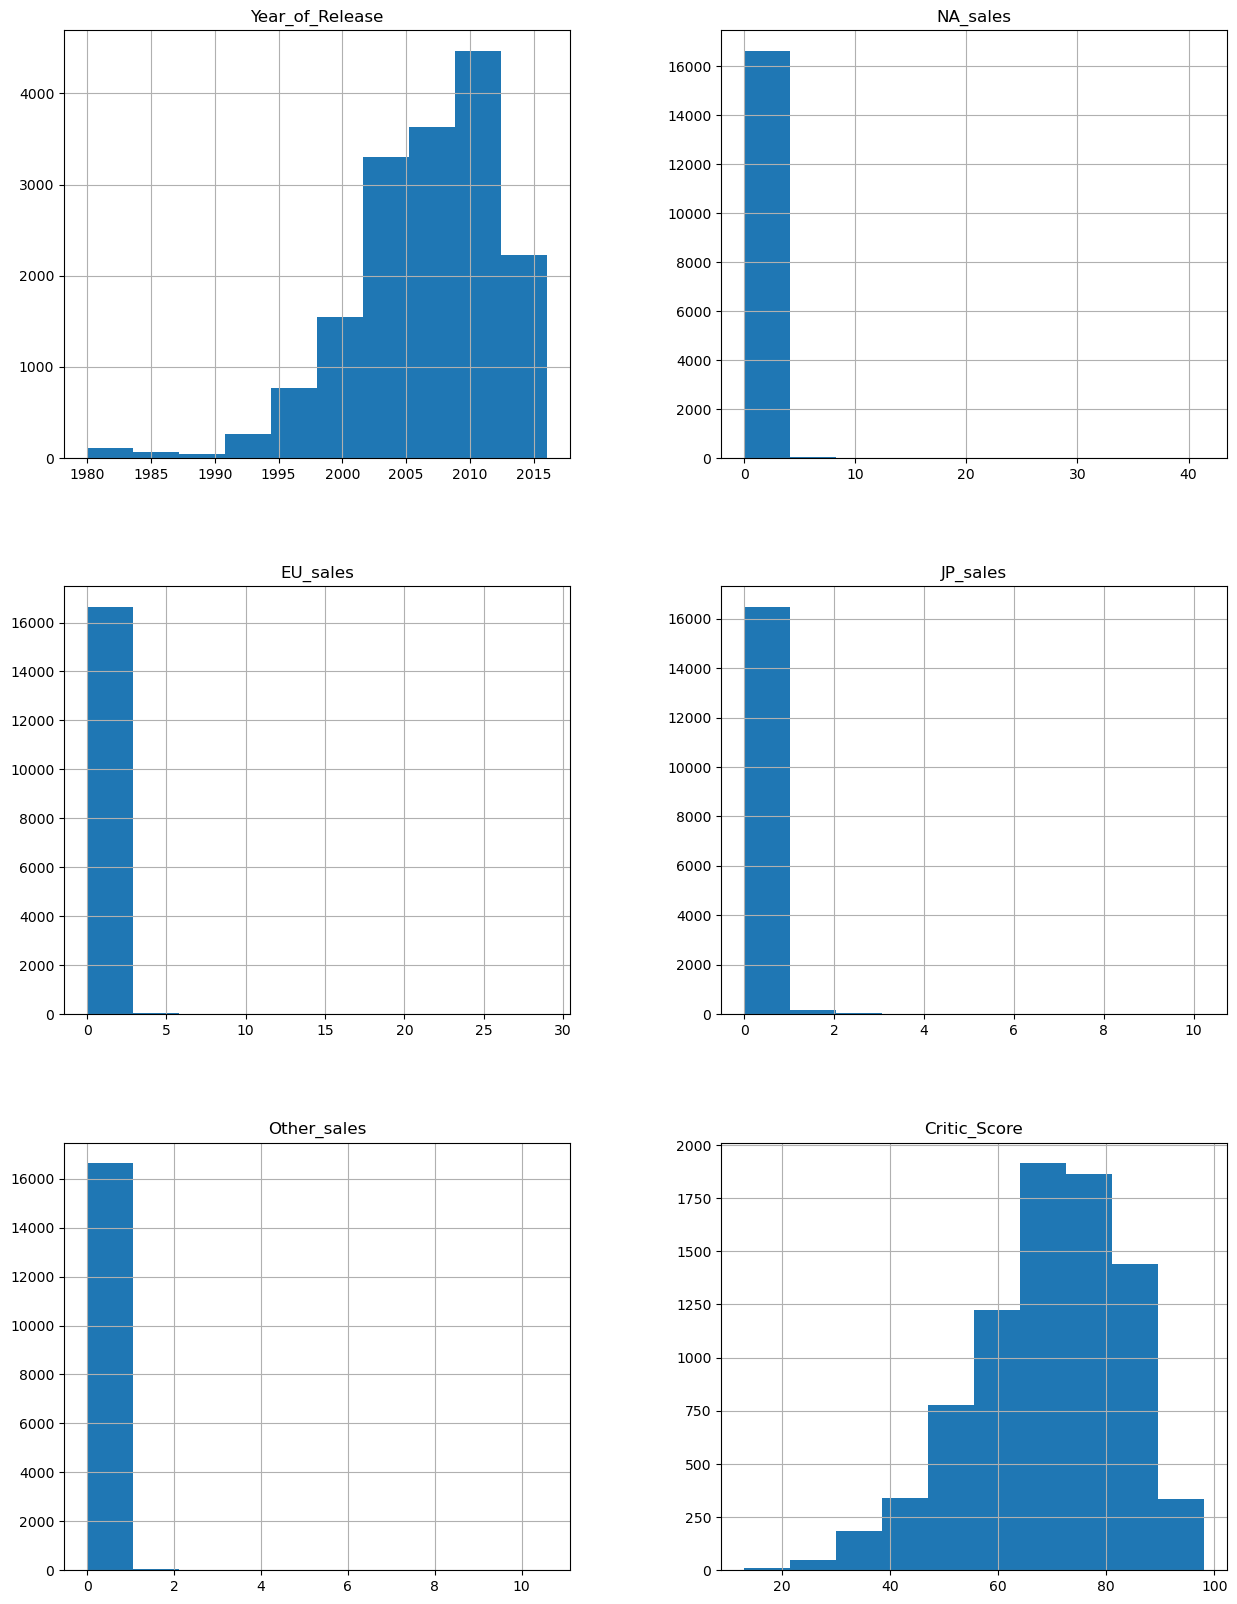

In [5]:
df.hist(figsize=(15,20))

**Вывод:**  
Данные представляют из себя таблицу: 11 столбцов на 16715 строк, размер 1.4 Mb.

## шаг. Подготовка данных.

### Измененеие названий столбцов.

In [6]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

### Изменение типов данных.

In [7]:
# Выведем типы данных 
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [8]:
# Заменим на тип float32 для экономии памяти
df['na_sales'] = df['na_sales'].astype('float32')

In [9]:
# Заменим на тип float32 для экономии памяти
df['eu_sales'] = df['eu_sales'].astype('float32')

In [10]:
# Заменим на тип float32 для экономии памяти
df['jp_sales'] = df['jp_sales'].astype('float32')

In [11]:
# Заменим на тип float32 для экономии памяти
df['other_sales'] = df['other_sales'].astype('float32')

In [12]:
# Выведем уникальный список значений столбца
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

**Вывод:**
Типы данных  в следующих столбцах целесообразно заменить:
- **year_of_release** : целесообразно заменить на int16 (год целое значение не более 2016), замена возможна после обработки пропусков;
- **_sales** : все столбцы с данными по продажам заменить на тип float32 для экономии памяти;
- **critic_score** : целесообразно заменить на int16 (рейтинги целые числа до 100), замена возможна после обработки пропусков;
- **user_score** : целесообразно заменить на float32 (этот рейтинг дробное число до 10), замена возможна после обработки пропусков и нечисловых значений.

### Обработка пропусков.

In [13]:
# Определим процент пропуков в столбцах
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

In [14]:
# Выведем строкис пропускми в названии
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [15]:
# Удалим отсутствущие значения в столбце 
df.dropna(subset=['name'], inplace=True)

In [16]:
# Посчитаем кол-вл пропусов в столбце
df['year_of_release'].isna().sum()

269

In [17]:
def year_find(name):
    """ 
    Функция вовращает по названию игры медиану года выпуска игр с аналогичным
    названием, так как производитель часто выпускают игры на многих платформах одновременно
    """
    try:
        return df[df['name'] == name]['year_of_release'].median().round(0)
    except:
        pass

In [18]:
# Применим функцию для замены пустых значений 'year_of_release' по названию аналогов
df.loc[df['year_of_release'].isna(), 'year_of_release'] = df.loc[df['year_of_release'].isna(), 'name'].apply(year_find)

In [19]:
# Посчитаем оставшиеся незаполненными строки
df['year_of_release'].isna().sum()

269

In [20]:
# Удалим оставшиеся незаполненными строки, их кол-во мало и они не повлияют на дальнейший анализ
df.dropna(subset=['year_of_release'],inplace=True)

In [21]:
# Убедимся, что пропусков не осталось
df['year_of_release'].isna().sum()

0

In [22]:
# Изменим тип данных на тип int16
df['year_of_release'] = df['year_of_release'].astype('int16')

In [23]:
df['year_of_release'].dtypes

dtype('int16')

In [24]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [25]:
# Посчитаем кол-во пропусков в столбце
df['critic_score'].isna().sum()

8461

In [26]:
def critic_score_find(name):
    """ 
    Функция вовращает по названию игры медиану оценки критиков с аналогичным
    названием, так как производитель часто выпускают игры на многих платформах одновременно
    """
    try:
        return df[df['name'] == name]['critic_score'].median().round(0)
    except:
        pass

In [27]:
# Применим функцию для замены пустых значений 'critic_score' по названию аналогов
df.loc[df['critic_score'].isna(), 'critic_score'] = df.loc[df['critic_score'].isna(), 'name'].apply(critic_score_find)

In [28]:
# Посмотрим сколько пропусков осталось в столбце
df['critic_score'].isna().sum()

8461

In [29]:
# Заменим оставшиеся пропуски в 'critic_score' медианным значением для соответствующего жанра
# df['critic_score'] = df.groupby(by='genre')['critic_score'].transform(lambda col: col.fillna(col.median()))

In [30]:
df['critic_score'].fillna(-1, inplace=True)

In [31]:
# Проверим остались ли пропуски в столбце
df['critic_score'].isna().sum()

0

In [32]:
# Преобразуем тип в данных в столбце к типу 'int16'.
df['critic_score'] = df['critic_score'].astype('int16')

In [33]:
df['critic_score'].dtypes

dtype('int16')

In [34]:
# Заменим значения 'tbd'  и пустые значения на numpy nan
df.loc[df['user_score'] == 'tbd' , 'user_score'] = np.nan

In [35]:
# Заменим пустые значения на numpy nan
df['user_score'].fillna(np.nan, inplace = True)

In [36]:
# Преобразуем тип данных к float32
df['user_score'] = df['user_score'].astype('float32')

In [37]:
# Проверим сколько пропуков 
df['user_score'].isna().sum()

8981

In [38]:
def user_score_find(name):
    """ 
    Функция вовращает по названию игры медиану оценки пользователей с аналогичным
    названием, так как производитель часто выпускают игры на многих платформах одновременно
    """
    try:
        return df[df['name'] == name]['user_score'].median().round(0)
    except:
        pass

In [39]:
# Применим функцию для замены пустых значений 'user_score' по названию аналогов
df.loc[df['user_score'].isna(), 'user_score'] = df.loc[df['user_score'].isna(), 'name'].apply(user_score_find)

In [40]:
# Проверим сколько пропуков осталось
df['user_score'].isna().sum()

8981

In [41]:
# Заменим оставшиеся пропущенные значения на -1
df['user_score'].fillna(-1, inplace=True)

In [42]:
# Убедимся, что все пропущенные значения заполнены
df['user_score'].isna().sum()

0

In [43]:
# Выведем список уникальных значений рейтинга
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [44]:
# Заменим K-A(это старое обозначение) на E
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'

In [45]:
# Посчитаем кол-во пропусков в играх после 2003, продававшихся в США
((df['rating'].isna()) & (df['year_of_release'] > 2003) & (df['na_sales'] > 0)).sum()

1355

In [46]:
# Общее кол-во пропусков в столбце
df['rating'].isna().sum()

6676

In [47]:
def rating_find(name):
    '''
    Функция возвращает значения моды рейтинга для переданного типа  жанра
    '''
    m = df[df['genre'] == name]['rating'].mode()
    return m[0]

In [48]:
''' Для игр, которые продавались в США после 2003 г. заменим пропущенные значения рейтинга на моду
для данного жанра игр'''
df.loc[(df['rating'].isna()) & (df['year_of_release'] > 2003) & (df['na_sales'] > 0), 'rating'] =\
df.loc[(df['rating'].isna()) & (df['year_of_release'] > 2003) & (df['na_sales'] > 0), 'genre'].apply(rating_find)

In [49]:
# Проверим сколько пустых значений рейтинга осталось
df['rating'].isna().sum()

5321

In [50]:
# Заполним оставшмеся пропуски значение "no_rating"
df['rating'].fillna('no_rating', inplace=True)

In [51]:
# Определим оставшийся процент пропуков в столбцах
df.isna().mean()

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
dtype: float64

In [52]:
# Создадим новый столбец с суммой продаж по всем регионам
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales','other_sales']].sum(axis=1)

In [53]:
df.dtypes

name                object
platform            object
year_of_release      int16
genre               object
na_sales           float32
eu_sales           float32
jp_sales           float32
other_sales        float32
critic_score         int16
user_score         float64
rating              object
total_sales        float32
dtype: object

In [54]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,-1,-1.0,no_rating,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,-1,-1.0,no_rating,31.380001


**Вывод:** 

Были обнаружены пропуски в следующих столбцах:
- **name** и **genre** : две строки с пропущенными значениями в эти двух столбцах, для нас будут бесполезны, были удалены;
- **year_of_release**  : точная дата, возможна была неизвестна. Некоторые производители выпускают игры сразу для нескольких платформ. Для таких игр можно использовать медианную дату их аналогов для других платформ, оставшиеся назаполненными удалим, так как их количество мало и не повлияет на дальнейший анализ;
- **critic_score**     : оценки для игр стали вестись не так давно, поэтому игры более ранних периодов таких рейтингов не имеют. Заполним пропущенные значения медианным рейтингом для аналогичного названия как с годом выпуска, остальные заменим нехарактерным значением;
- **user_score**       : оценки для игр стали вестись не так давно, поэтому игры более ранних периодов таких рейтингов не имеют. В столбце есть значения 'tbd' (to be determined), то есть оценка еще не определена, возможна игра не вышла официально итд. Считаю, что для нас это аналогично отсутствию оценки, заменим их на nan. После этого заполним пропущенные значения медианным рейтингом для аналогичного названия как с годом выпуска, остальные заменим нехарактерным значением;
- **rating**           : этот рейтинг от организации ESRB был впервые введен в 1994 г., однако его присвоение стало фактически обязательным для продаж в США намного позже. Заменим пропущенные значения только для игр, вышедших после 2003 г. и продававшихся США, на наиболее часто встречавшееся значение для игр данного жанра. Остальные заменим на 'no_rating'. Также заменим рейтинг 'K+A'(он больше не применяется) на 'E', это его аналог сейчас.   

После замены пропущенных значений типы данных были преобразованы в те, на которые планировалось.

## шаг. Исследовательский анализ данных

In [55]:
# Загрузим бибилотеку 
import matplotlib.pyplot as plt

### Посмотрим, сколько игр выпускалось в разные годы.

<AxesSubplot:xlabel='year_of_release'>

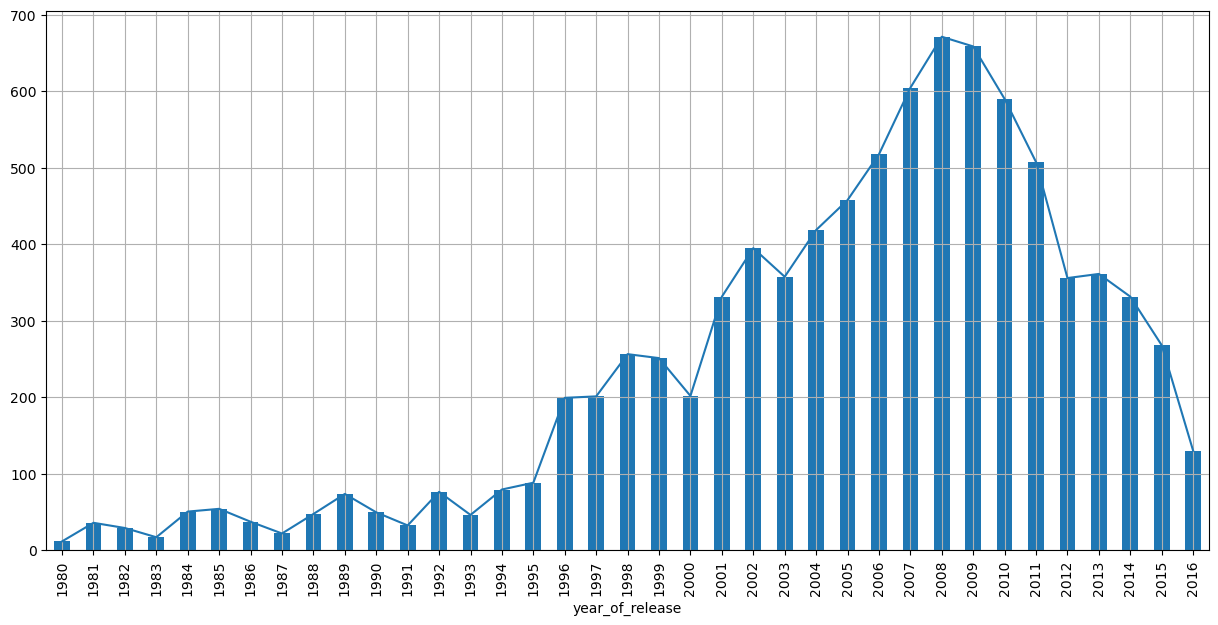

In [56]:
ax = df.groupby('year_of_release')['total_sales'].sum().plot(kind='bar', figsize=(15,7))
# ax.xaxis.set_visible(False)
df.groupby('year_of_release')['total_sales'].sum().plot(grid=True, use_index=False, figsize=(15,7), ax=ax, rot=90)


**Вывод:**  
С 1980 г. продажи игр неуклонно росли почти 30 лет подряд, вплоть до 2008 г., теперь же они неуклонно снижаются 8-ой год.

### Выявим лидеров по продажам среди платформ.

In [57]:
# Выведем сортированный по продажам список платформ 
df.groupby('platform')['total_sales'].sum().sort_values().tail(10)

platform
3DS      257.809998
PSP      289.529999
GBA      312.880005
PS4      314.140015
PS       727.580017
DS       802.780029
Wii      891.179993
PS3      931.339966
X360     961.239990
PS2     1233.559937
Name: total_sales, dtype: float32

Выведем графики самых продаваемых платформ, а также, если такие существуют, следующие за ними в линейке каждого производителя.

<AxesSubplot:xlabel='year_of_release'>

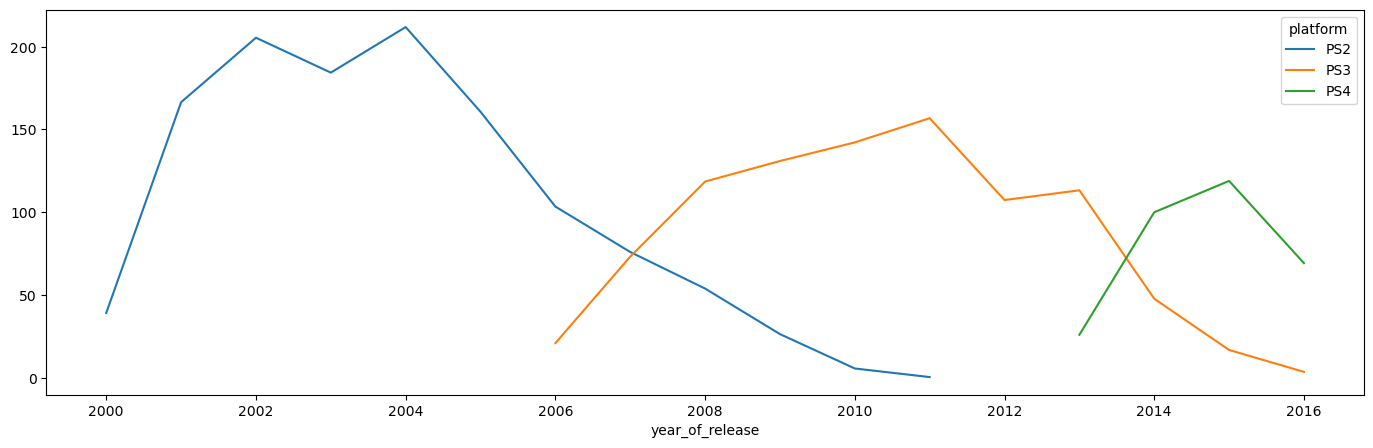

In [58]:
# Для Sony
df.query('(platform == "PS2") or(platform == "PS3") or (platform == "PS4") ').\
pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(17,5))

<AxesSubplot:xlabel='year_of_release'>

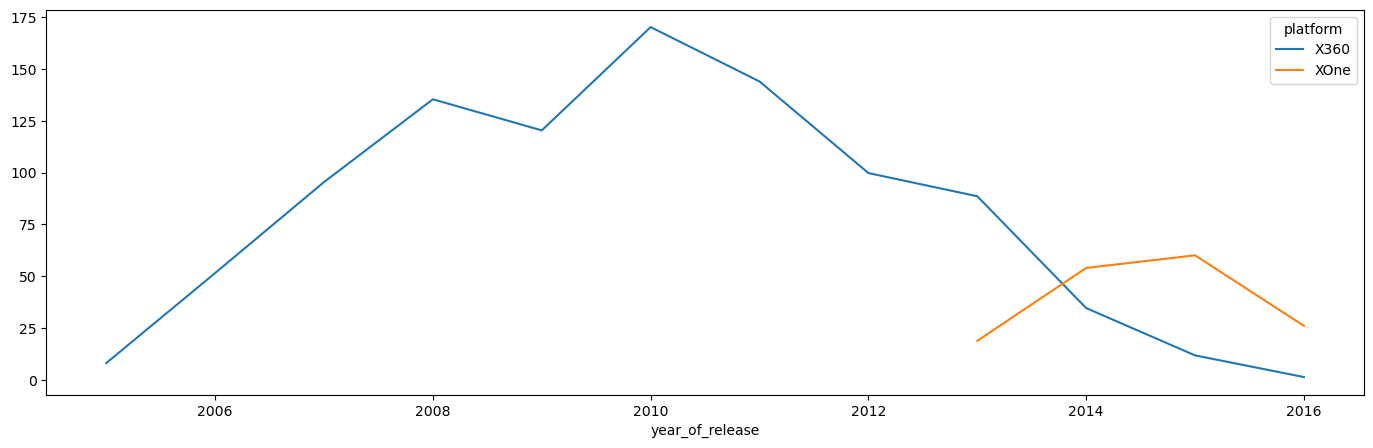

In [59]:
# Для Microsoft
df.query('(platform == "X360") or(platform == "XOne")').\
pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(17,5))

<AxesSubplot:xlabel='year_of_release'>

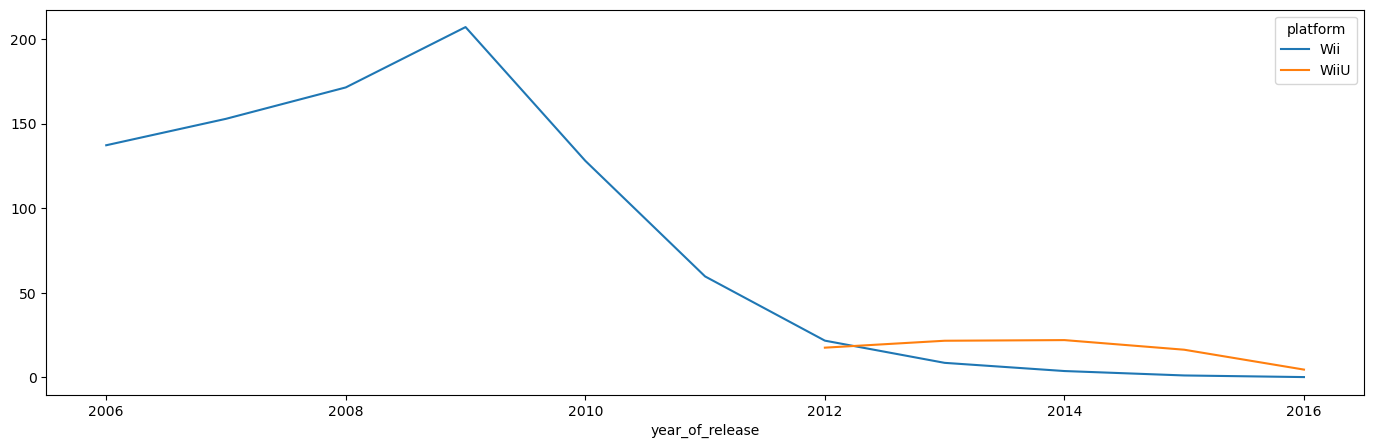

In [60]:
# Для Nintendo
df.query('(platform == "Wii") or(platform == "WiiU")').\
pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(figsize=(17,5))

<AxesSubplot:xlabel='year_of_release'>

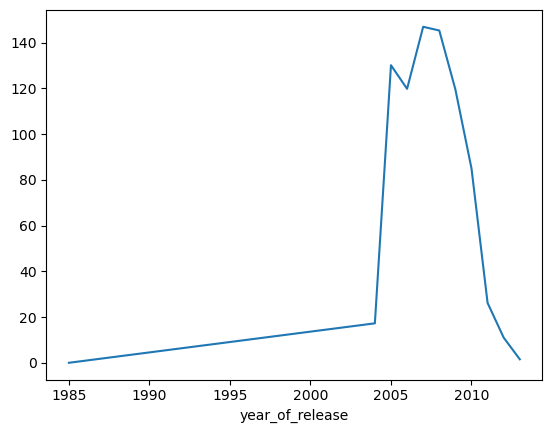

In [61]:
# Nintendo DS карманная консоль
df[df['platform'] == 'DS'].groupby('year_of_release')['total_sales'].sum().plot()

Выведем еще дополнительно график продажи игр на настольных компьютеров, хотя по уровню продаж они замыкает десятку лидеров.

<AxesSubplot:xlabel='year_of_release'>

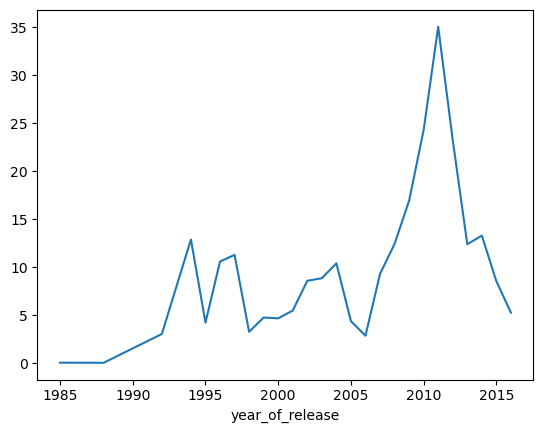

In [62]:
# График для игр для персональных компьютеров 
df[df['platform'] == 'PC'].groupby('year_of_release')['total_sales'].sum().plot()

**Вывод:**  
Рейтинг лидеров выгдяит следующим образом:

       PS2  
       X360
       PS3
       Wii
       DS
       PS
       GBA
       PS4
       PSP
       PC     
   
В топ-10 вся линейка Sony, X360 от Microsoft, естественно Nintendo и настольные компьютеры. Но это за весь период наблюдений, а нас же интересуют последние тенденции.
Жизненный цикл консолей лидеров (и соотвественно выпуска игр для них) порядка 10 лет, примерно каждые 5 лет производители запускают следующую платформу в линейке. Судя по графикам после 2008 г. каждая последующая в линейке платформа менее успешна прдыдущей (если судить по продажам игр для них.) и ее жизненный цикл, возможно, будет короче почти вдвое.
Отдельно следует отметить персональные компьютеры, так как игры для них продаются уже 30 лет, продажи уменьшаются в соответсвии с общей тенденцией, но замыкают десятку лидеров.

### Посмотрим какие платформы лидируют по продажам, растут или падают.

<AxesSubplot:title={'center':'Sales of Platfroms per last 5 Years'}, xlabel='year_of_release', ylabel='sales_summary'>

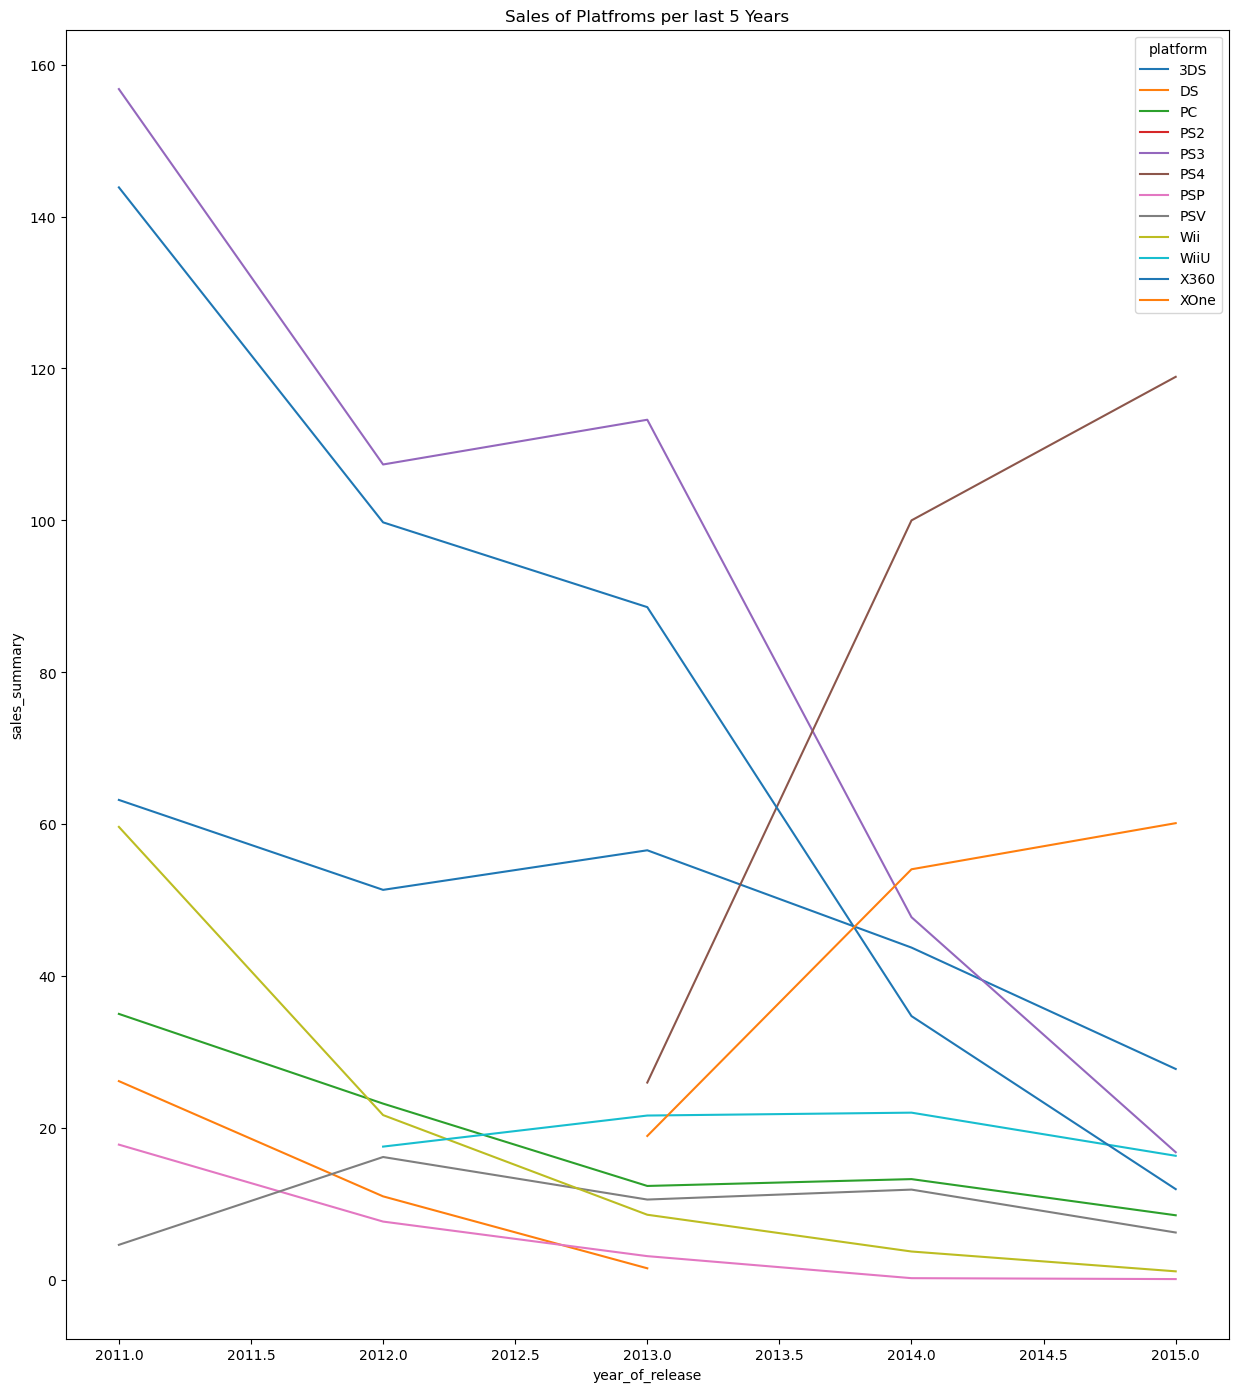

In [63]:
# Построим графики для платформ за последние 5 лет
df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2016)].pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc='sum').plot(figsize=(15,17), ylabel='sales_summary', title='Sales of Platfroms per last 5 Years')


<AxesSubplot:title={'center':'Sales of Platforms per last year'}, xlabel='year_of_release', ylabel='sales_summary'>

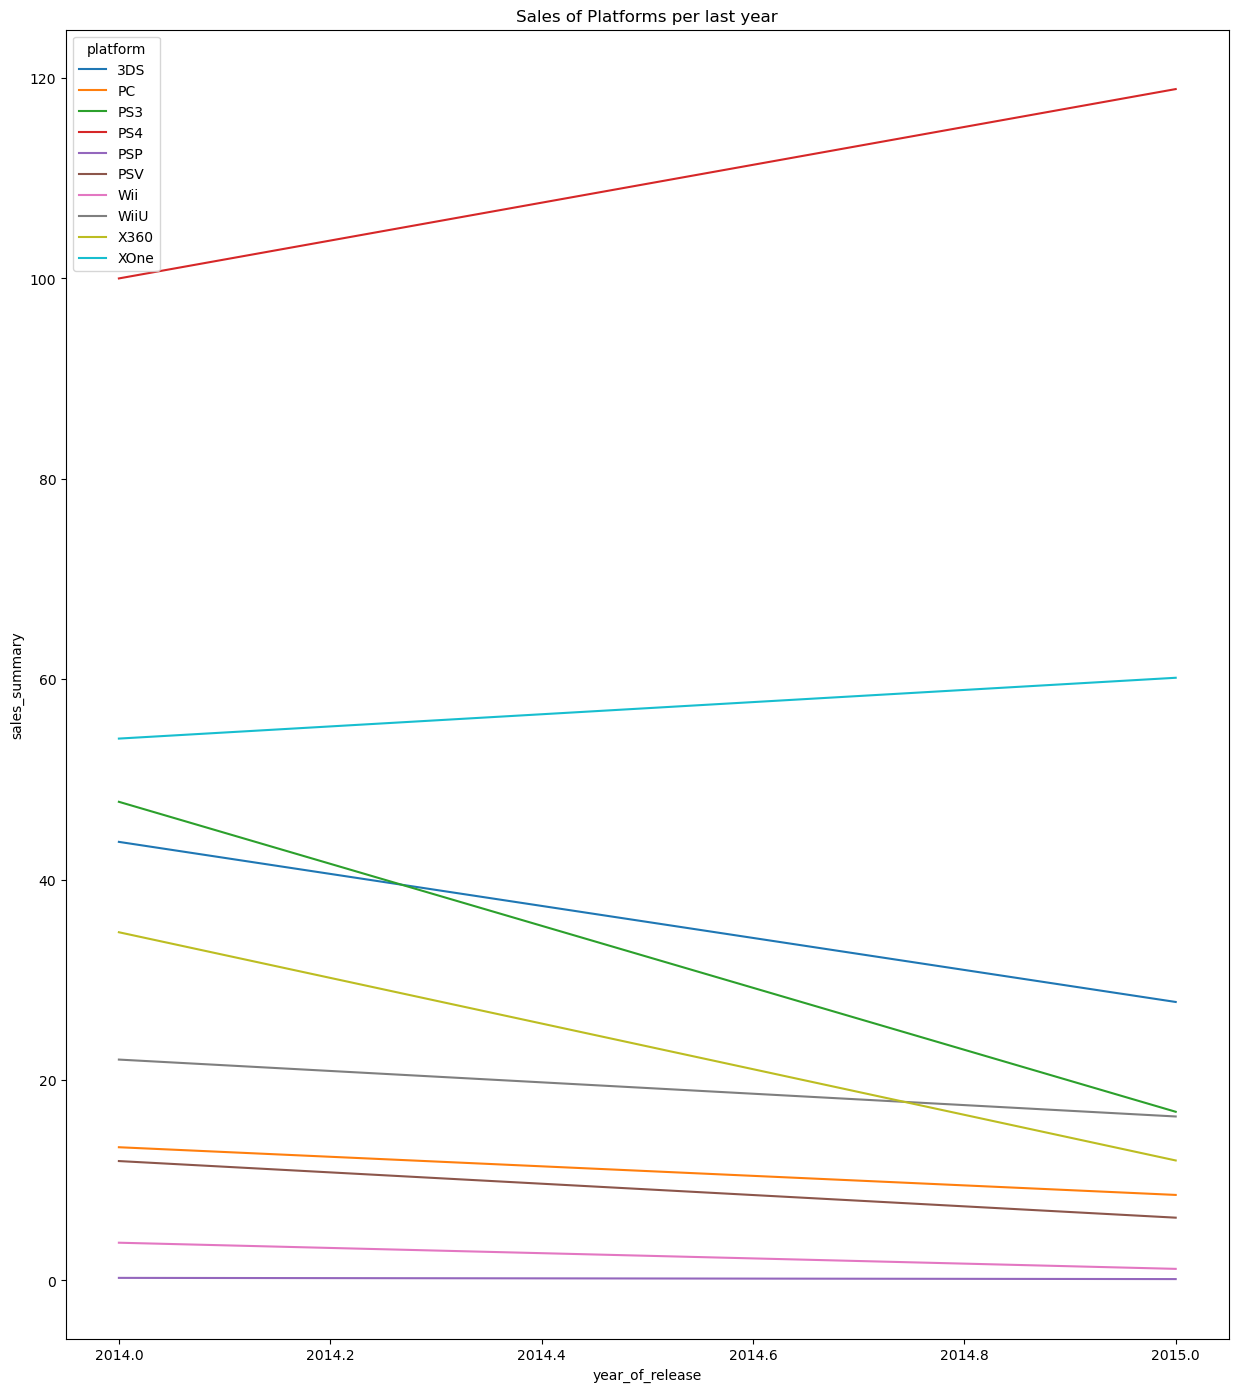

In [64]:
# Построим графики для платформ за 2014/2015 год.
df[(df['year_of_release'] >= 2014) & (df['year_of_release'] < 2016)].pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc='sum').plot(figsize=(15,17), ylabel='sales_summary', title='Sales of Platforms per last year')

**Вывод:**  
Только две платформы показывали рост в последние годы: PS4 и XOne, WiiU имеет практически нейтральную тенденцию. Все остальные платформы снижаются.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

In [65]:
# Загрузим библиотеку seaborn
import seaborn as sns

In [66]:
# Сгрупируем данные выбранных нами лидеров
df_lead = df.query('(platform =="PS4") or (platform == "XOne") or (platform == "WiiU") or (platform == "PC")')

(0.0, 3.0)

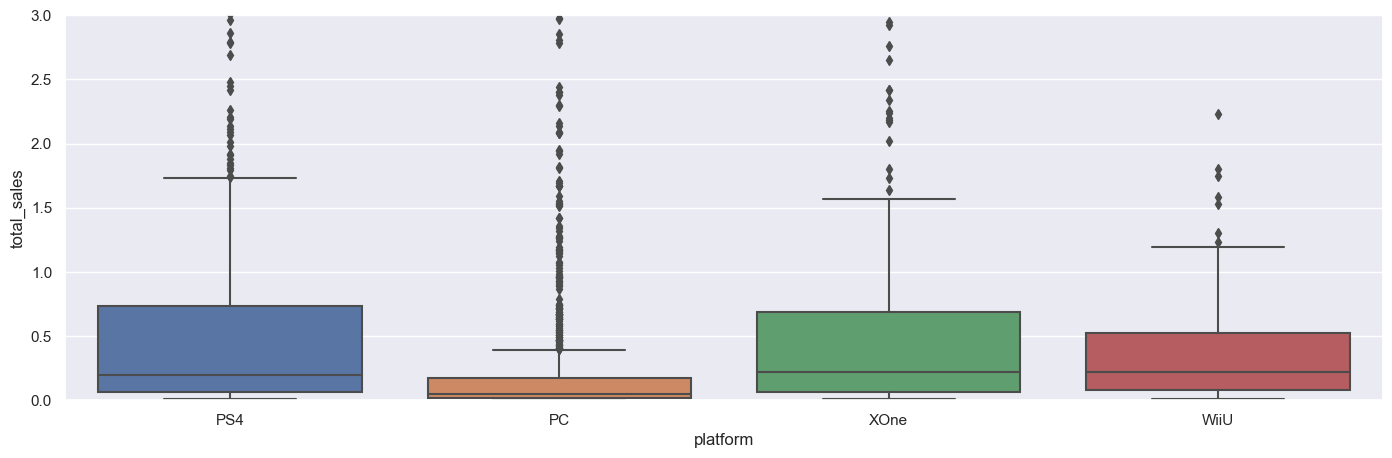

In [67]:
# Построим boxplot  в seaborn
sns.set(rc={'figure.figsize':(17,5)})
box = sns.boxplot(data=df_lead, x='platform', y='total_sales')
box.set_ylim(0,3)

**Вывод:**  
Следует отметить большое кол-во сильных выбросов у всех платформ. Это может говорить о том, что есть отдельные игры (и таких игр не так уж и мало) объем продаж которых существенно превосходит объемы продаж по остальным играм для платформы. Медианы у всех лидеров последних годов примерно одинаковые.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Выберем для этого PS4, так как у нее самый хороший рост.

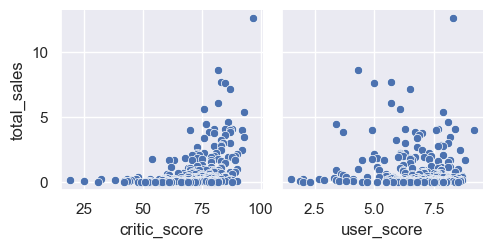

In [68]:
# Выберем платформу и исключим из расмотрения выставленные нами нехарактерные значения
df_ps4 = df.query('(platform == "PS4") and (critic_score != -1) and (user_score != -1)')
sns.pairplot(df_ps4, x_vars=['critic_score','user_score'], y_vars='total_sales', diag_kind="scatter")

In [69]:
# Построим матрицу корреляции для ннтересующих нас столбцов
df_ps4[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.405895,-0.033625
critic_score,0.405895,1.000000,0.557654
user_score,-0.033625,0.557654,1.000000


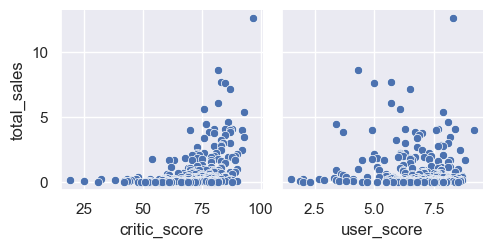

In [70]:
# Проверим тоже для платформы Xone
df_xone = df.query('(platform == "XOne") and (critic_score != -1) and (user_score != -1)')
sns.pairplot(df_ps4, x_vars=['critic_score','user_score'], y_vars='total_sales', diag_kind="scatter")

In [71]:
# Посчитаем корреляцию для выбранных столбцов
df_xone[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.410422,-0.094003
critic_score,0.410422,1.000000,0.472462
user_score,-0.094003,0.472462,1.000000


In [72]:
# Посмотрим корреляцию в целом по дата-фрейму
df[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.148033,0.134934
critic_score,0.148033,1.000000,0.819356
user_score,0.134934,0.819356,1.000000


**Вывод:**  
Отзывы критиков слабо влияют на продажи игр, а пользоватей вообще не влияют.

### Посмотрим на общее распределение игр по жанрам.

Посмотрим  как весь период, а также рассмотрим последние 5 лет.

<AxesSubplot:ylabel='total_sales'>

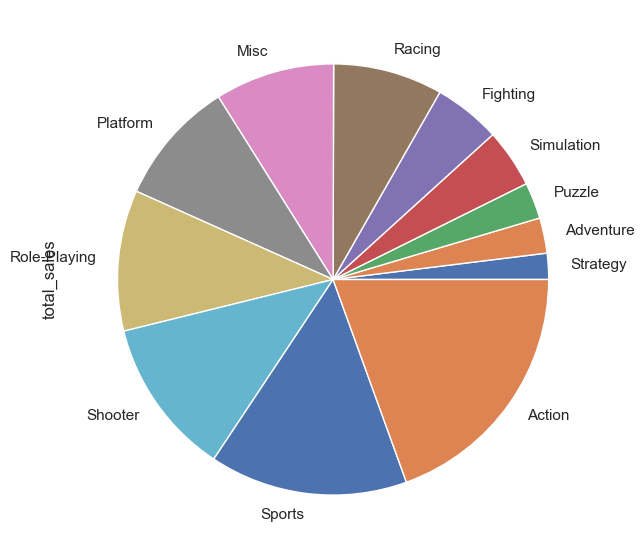

In [73]:
# Распределение по сумамрному объему продаж по жанрам за весь период наблюдений.
df.groupby('genre')['total_sales'].sum().sort_values().plot(kind='pie', figsize=(15,7))

<AxesSubplot:ylabel='total_sales'>

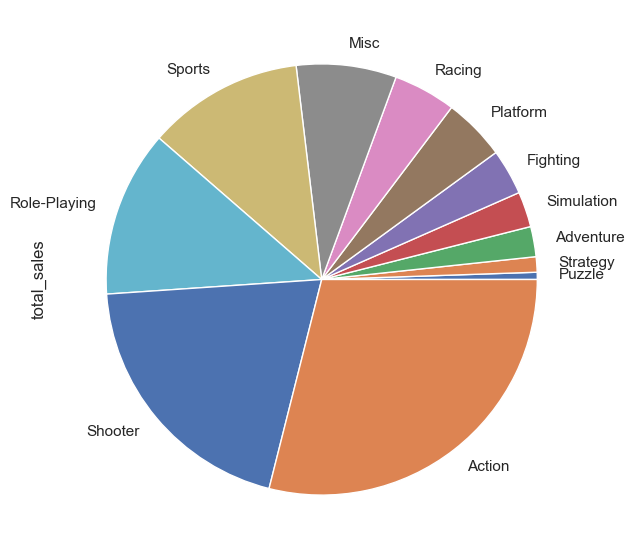

In [74]:
# Тоже распределение по сумамрному объему, но за последние 5 лет
df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2016)].groupby('genre')['total_sales'].sum().sort_values().plot(kind='pie', figsize=(15,7))

Спортивные игры явно уступили свои позиции, как и жанр Platform, хотя ранее были очень популярны.

In [75]:
# Посмотрим сколько игр каждого жанра продавалось за последние 5 лет и сколько в среднем приносила каджая игра
df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2016)].groupby(['year_of_release', 'genre'])['total_sales'].agg(['sum','count', 'median', 'mean']).sort_values(by='mean', ascending=False)

sum  count  median      mean
year_of_release genre                                            
2015            Shooter        67.510002     34   0.925  1.985588
2012            Platform       18.370001     11   0.150  1.670000
                Shooter        71.750000     48   0.415  1.494792
2014            Shooter        65.209999     47   0.660  1.387447
2013            Shooter        62.040001     59   0.340  1.051525
2011            Shooter        98.180000     94   0.345  1.044468
2014            Platform        8.810000     10   0.830  0.881000
                Sports         45.150002     54   0.460  0.836111
2013            Action        122.510002    147   0.200  0.833401
                Sports         41.169998     53   0.370  0.776792
                Racing         12.370000     16   0.340  0.773125
2011            Platform       27.680000     37   0.150  0.748108
2012            Simulation     13.360000     18   0.195  0.742222
2015            Sports         40.840000     59   0.120  0.692203
2014            Fighting       15.849999     23   0.130  0.689130
2013            Platform       24.540001     36   0.385  0.681667
                Role-Playing   44.450001     71   0.180  0.626056
2014            Racing         16.660000     27   0.170  0.617037
2013            Misc           25.270000     42   0.175  0.601667
2012            Role-Playing   46.910000     78   0.180  0.601410
                Misc           22.220001     37   0.190  0.600541
                Sports         30.420000     54   0.280  0.563333
2014            Misc           23.379999     42   0.160  0.556667
2011            Role-Playing   52.829998     95   0.190  0.556105
                Racing         34.810001     65   0.160  0.535538
2014            Action         97.230003    188   0.205  0.517181
                Role-Playing   45.619999     89   0.110  0.512584
                Simulation      5.580000     11   0.120  0.507273
2011            Action        116.680000    238   0.190  0.490252
2015            Role-Playing   37.639999     78   0.105  0.482564
2013            Simulation      8.630000     18   0.105  0.479444
2015            Platform        6.050000     13   0.100  0.465385
2011            Sports         56.080002    121   0.170  0.463471
2012            Racing         13.610000     30   0.245  0.453667
                Action        119.250000    265   0.170  0.450000
2015            Racing          8.070000     18   0.150  0.448333
2011            Fighting       22.410000     50   0.260  0.448200
2015            Simulation      5.660000     15   0.200  0.377333
                Fighting        7.900000     21   0.100  0.376190
2013            Fighting        7.090000     20   0.155  0.354500
                Strategy        6.120000     19   0.190  0.322105
                Puzzle          0.960000      3   0.100  0.320000
2012            Fighting        9.180000     29   0.190  0.316552
2011            Misc           54.379997    183   0.130  0.297158
2015            Misc           11.570000     39   0.190  0.296667
                Action         72.019997    253   0.070  0.284664
2011            Simulation     15.139999     56   0.090  0.270357
2012            Strategy        3.260000     15   0.090  0.217333
2014            Puzzle          1.490000      7   0.050  0.212857
2011            Strategy        8.820000     46   0.075  0.191739
2012            Puzzle          1.720000     11   0.020  0.156364
2015            Adventure       8.160000     54   0.030  0.151111
2011            Adventure      15.610000    108   0.040  0.144537
2014            Strategy        0.980000      8   0.060  0.122500
2015            Puzzle          0.710000      6   0.045  0.118333
                Strategy        1.850000     16   0.045  0.115625
2011            Puzzle          4.960000     43   0.050  0.115349
2012            Adventure       5.790000     57   0.040  0.101579
2013            Adventure       6.090000     60   0.025  0.101500
2014       

In [76]:
# Графики средней медианной выручки игры по жанрам за последние 5 лет
df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2016)].pivot_table(index='year_of_release', columns='genre', values='total_sales', aggfunc='median')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2011,0.190,0.040,0.260,0.130,0.150,0.050,0.160,0.190,0.345,0.090,0.17,0.075
2012,0.170,0.040,0.190,0.190,0.150,0.020,0.245,0.180,0.415,0.195,0.28,0.090
2013,0.200,0.025,0.155,0.175,0.385,0.100,0.340,0.180,0.340,0.105,0.37,0.190
2014,0.205,0.040,0.130,0.160,0.830,0.050,0.170,0.110,0.660,0.120,0.46,0.060
2015,0.070,0.030,0.100,0.190,0.100,0.045,0.150,0.105,0.925,0.200,0.12,0.045


<AxesSubplot:xlabel='year_of_release'>

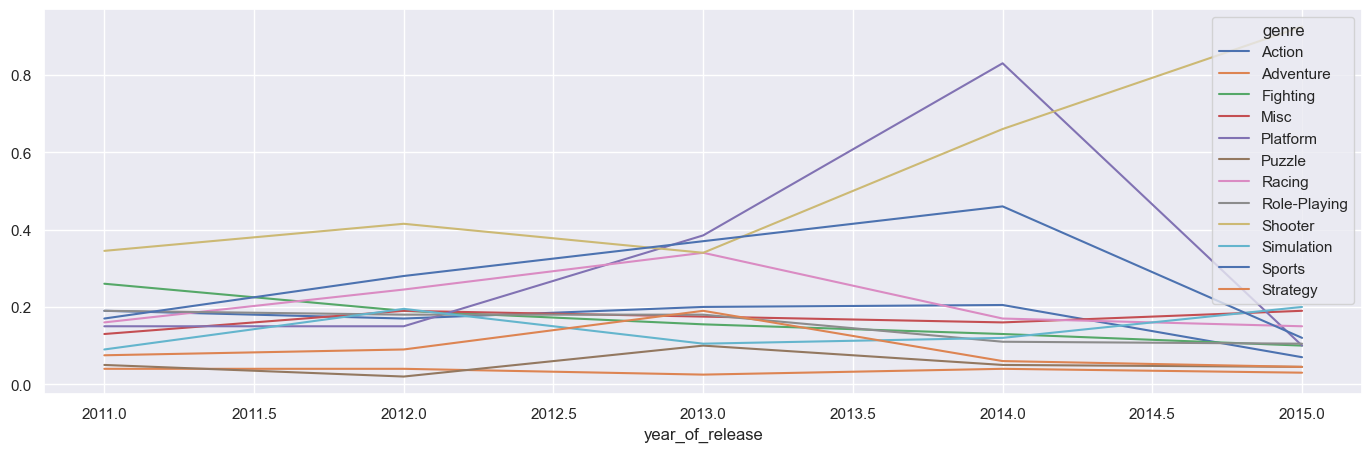

In [77]:
# Графики средней медианной выручки игры по жанрам за последние 5 лет
df[(df['year_of_release'] > 2010) & (df['year_of_release'] < 2016)].pivot_table(index='year_of_release', columns='genre', values='total_sales', aggfunc='median').plot(figsize=(17,5))

**Вывод:**  
Если брать суммарный объем продаж за последние пять лет, на первом месте жанр Action, его практически догнал жанр Shooter, третье/четвертое место делят между собой ролевые и спортивные игры. Спортивные игры явно уступили свои позиции, как и жанр Platform, хотя ранее были очень популярны и, если брать весь период наблюдений, то они займут 2-ое и 5-ое места соответственно. Головоломки и стратегия традиционно на последних местах - выпускают мало игр этих жанрво и мало продают, так как люди предпочитают отдыхать, а не думать головой во время игры.  
Однако самым продаваемы стал жанр Shooter, в 2015 г. выручка на одну игру этого жанра почти в 4 раза превышала игры из любых других жанров. Рост наблюдается с 2013 года.

## шаг.  Составление портрета пользователя каждого региона.

<AxesSubplot:xlabel='year_of_release'>

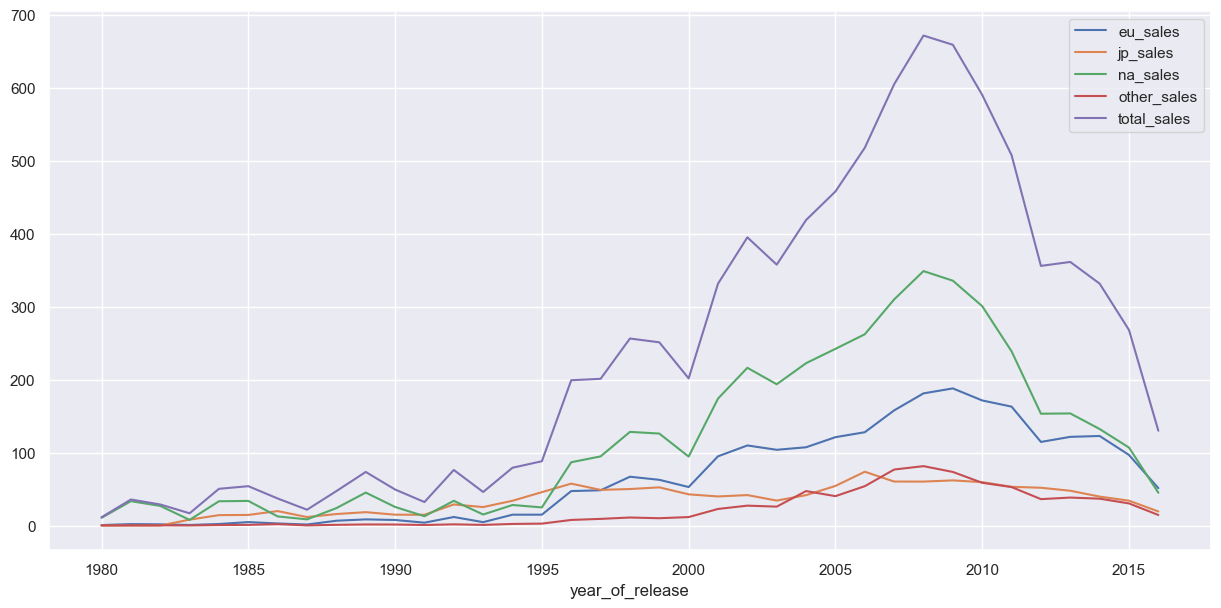

In [78]:
# Построим графики продаж по регионам
df.pivot_table(index='year_of_release', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], aggfunc='sum').plot(figsize=(15,7))

На первом месте по продажам США, далее Европа, доля Японии примерно равна продажам всего остального мира. Графики повторяют друг друга, отличается только масштаб.

### Самые популярные платформы (топ-5) по регионам.

array([<AxesSubplot:ylabel='na_sales'>, <AxesSubplot:ylabel='eu_sales'>,
       <AxesSubplot:ylabel='jp_sales'>], dtype=object)

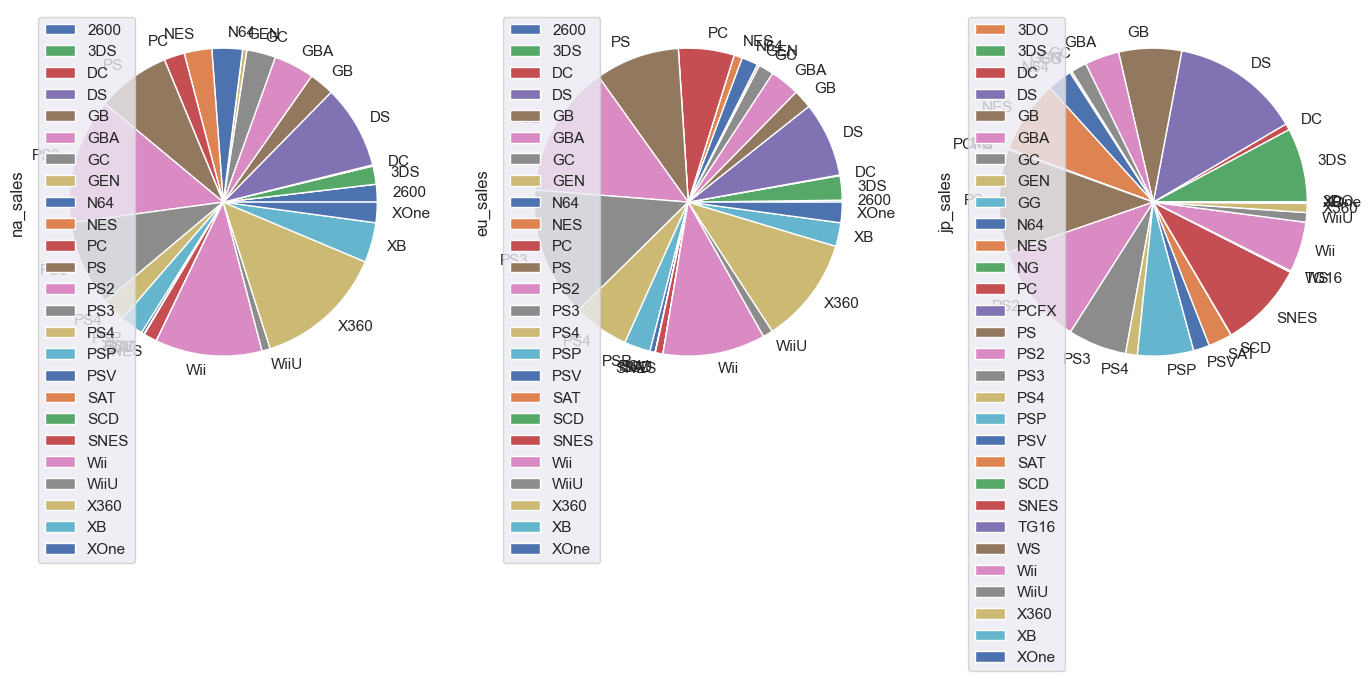

In [79]:
# Диаграммы по платформам по регионам
df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum().plot(kind='pie', subplots=True, figsize=(17,5))

<AxesSubplot:xlabel='platform'>

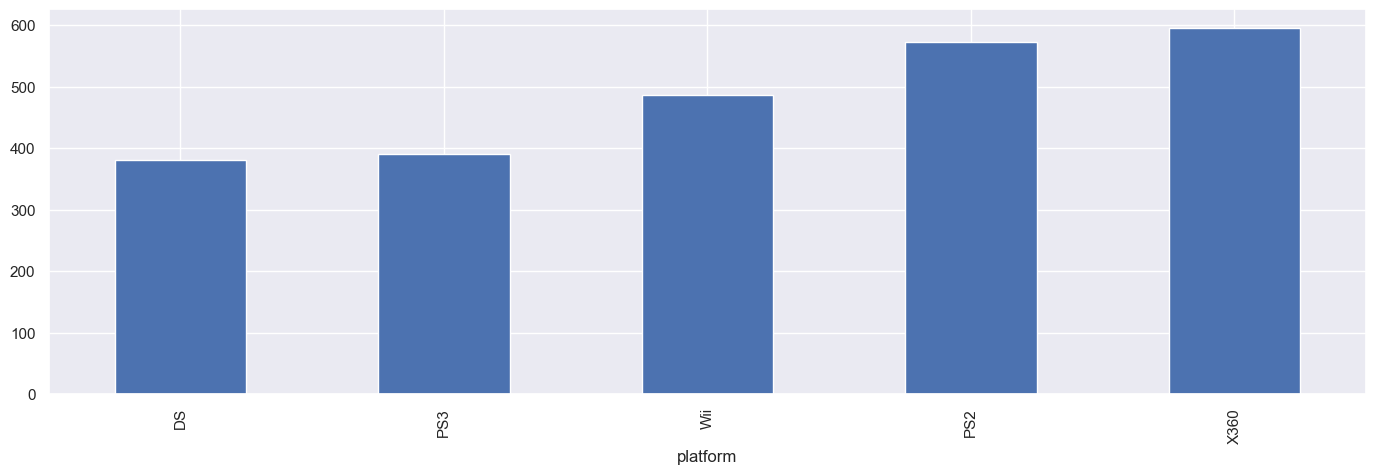

In [80]:
# График топ-5 для США
df.groupby('platform')['na_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

<AxesSubplot:xlabel='platform'>

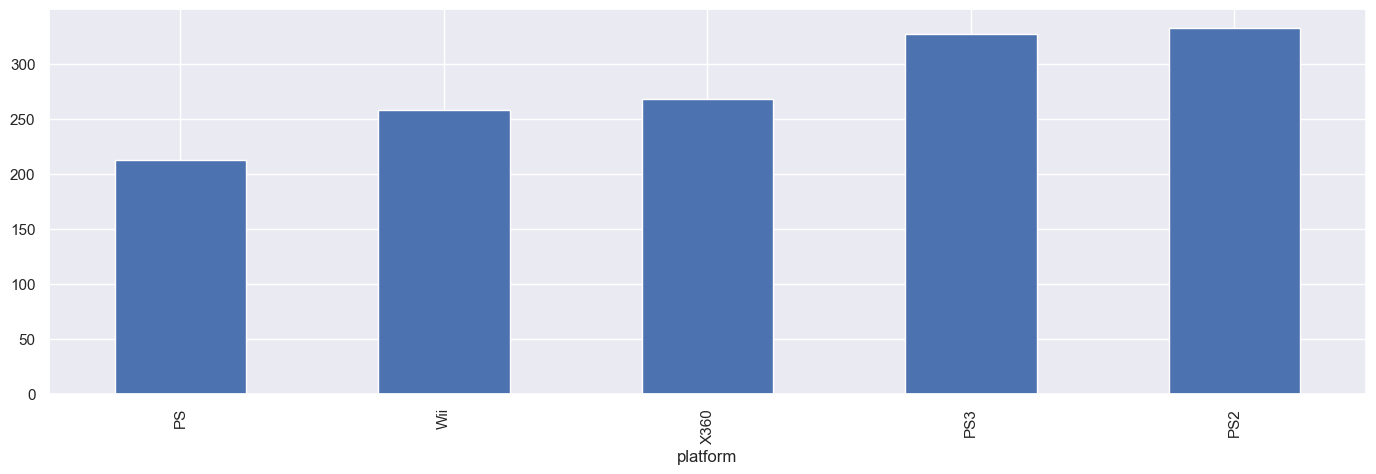

In [81]:
# График топ-5 для Европы
df.groupby('platform')['eu_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

<AxesSubplot:xlabel='platform'>

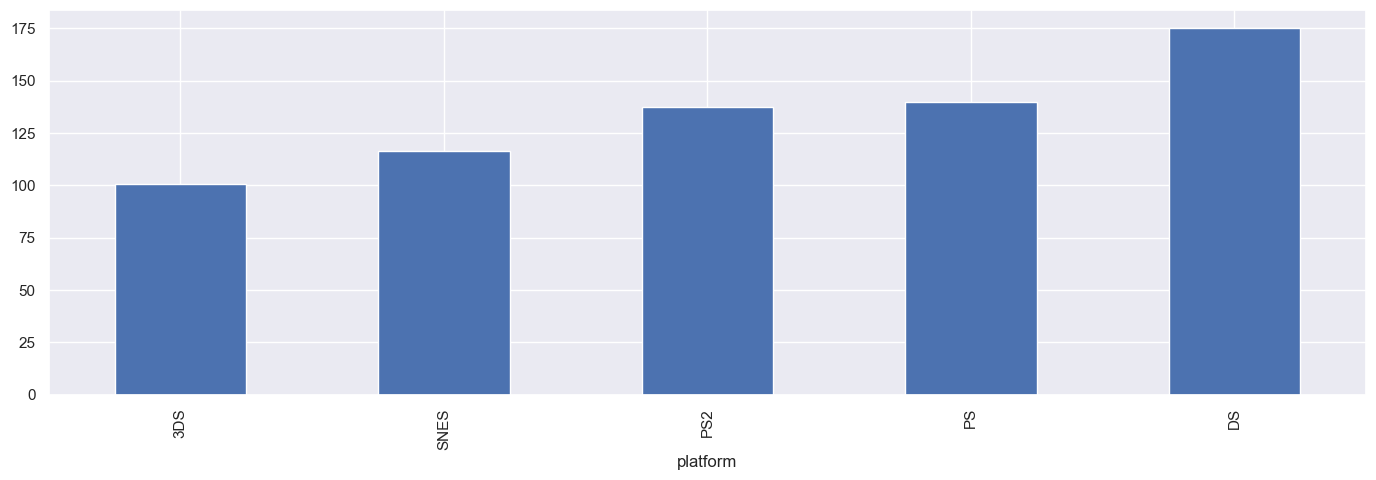

In [82]:
# График топ-5 для Японии
df.groupby('platform')['jp_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

**Вывод:** 

Топ-5 платформ по странам:

    США     Европа   Япония
    X360     PS2      DS
    PS2      PS3      PS
    Wii      X360     PS2
    PS3      Wii      SNES
    DS       PS       3DS



*Продажи по платформам различаются в зависимости от региона. В Японии в лидерах компания Nintendo, в том числе в лидерах 2 консольные платформы. Ее платформа Wii среди лидеров в Европе и США, а вот на своей родине она не стала столь популярной. В США на первом месте естественно Microsoft с X360. Платформы Sony представлены среди лидеров всех регионом, но в Европе они занимают 3 из  5-ти лидерских позиций.*

### Самые популярные жанры (топ-5) по регионам. 

array([<AxesSubplot:ylabel='na_sales'>, <AxesSubplot:ylabel='eu_sales'>,
       <AxesSubplot:ylabel='jp_sales'>], dtype=object)

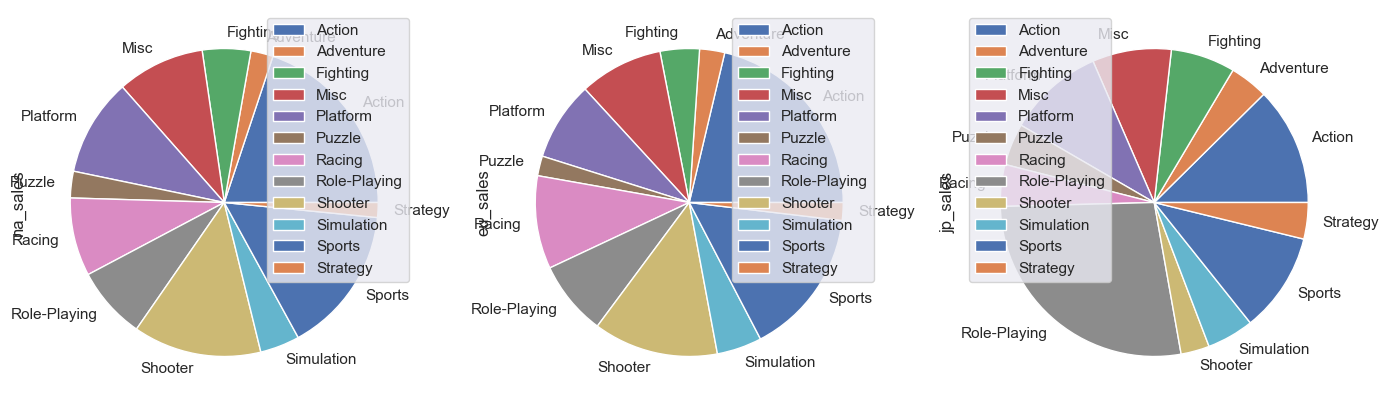

In [83]:
# Диаграммы по жанрам по регионам
df.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum().plot(kind='pie', subplots=True, figsize=(17,5))

<AxesSubplot:xlabel='genre'>

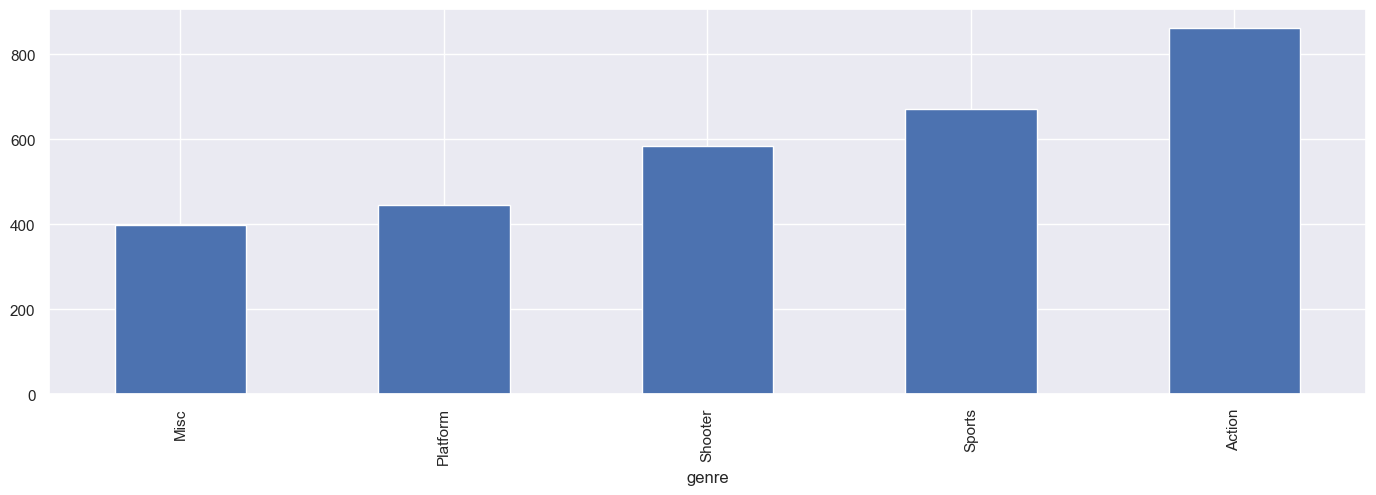

In [84]:
# График топ-5 для США
df.groupby('genre')['na_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

<AxesSubplot:xlabel='genre'>

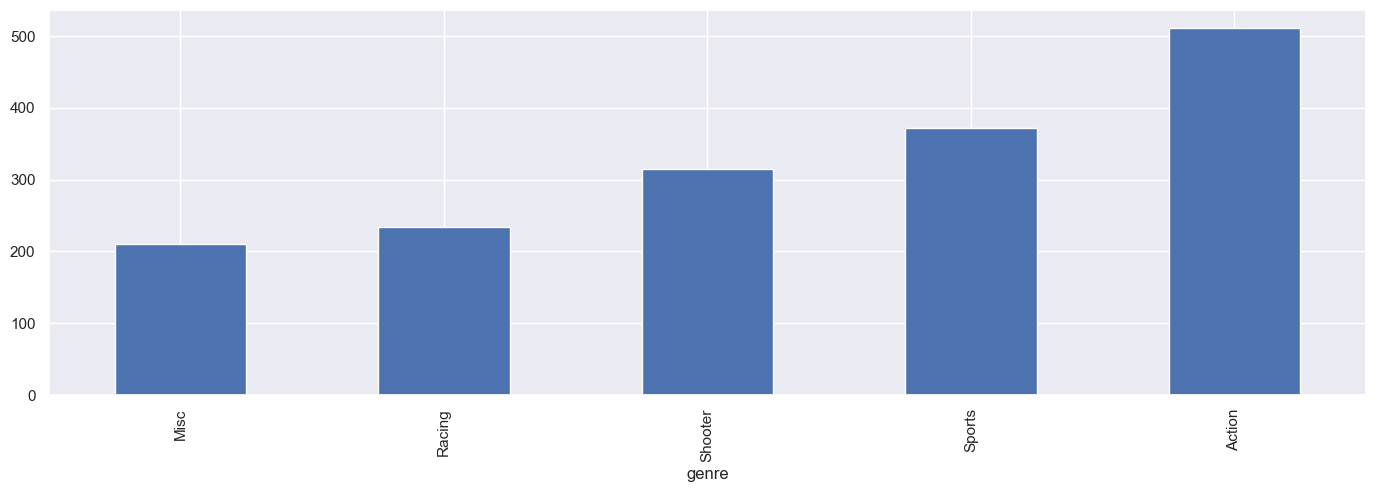

In [85]:
# График топ-5 для Европы
df.groupby('genre')['eu_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

<AxesSubplot:xlabel='genre'>

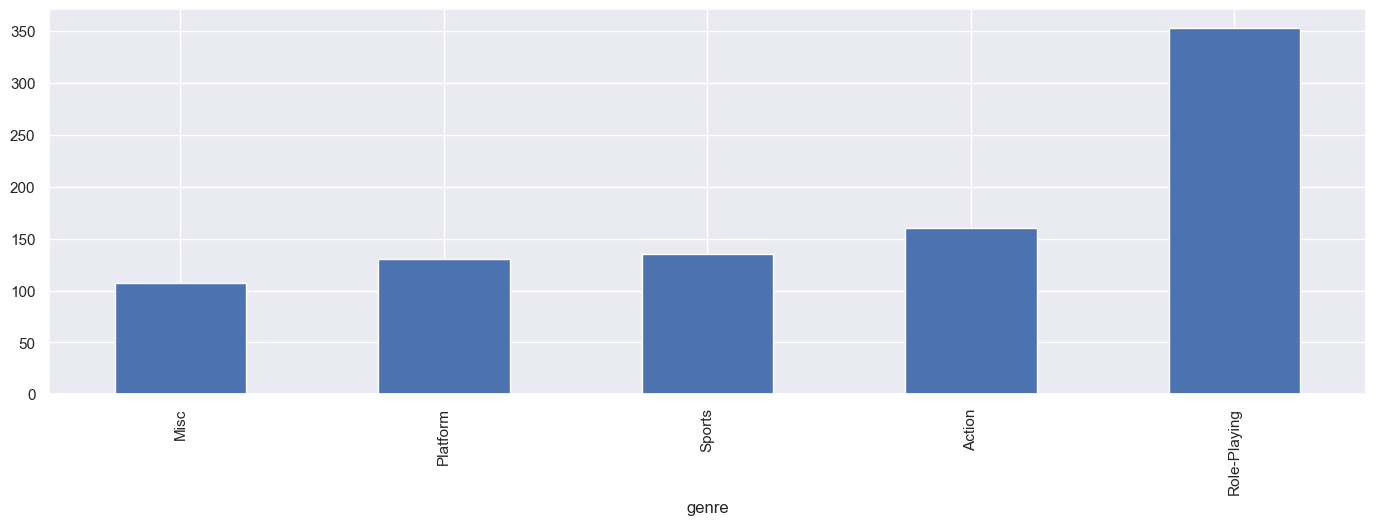

In [86]:
# График топ-5 для Японии
df.groupby('genre')['jp_sales'].sum().sort_values().tail(5).plot(kind='bar', figsize=(17,5))

**Вывод:** 

Топ-5 жанров по странам:

    США     Европа   Япония
    Action   Action  Role-Playing
    Sports   Sports  Action
    Shooter  Shooter Sports
    Platform Racing  Platform
    Misk     Misk    Misk

*Различия ясно видны даже на круговых диаграммах. Жанровые предпочтения европейцев и жителей США практически аналогичны, только в Европе любят больше гонки, чем Platform. А вот японцы явно не любят стрелялки, почти всю их долю забрали себе ролевые игры (они занимают более четверти всех проданных игр), также японцы чуть больше любят стретегии и приключения, и меньше гонки, распределение остальных жанров у них схоже.*

### Влияние рейтинг ESRB на продажи в отдельном регионе.

<AxesSubplot:xlabel='rating'>

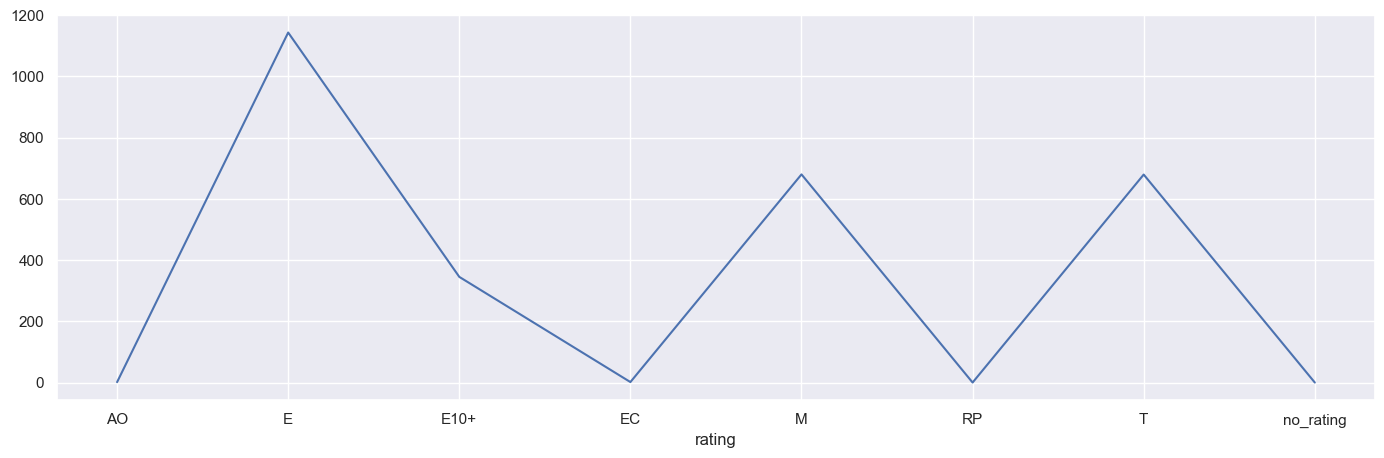

In [87]:
# Выведем график зависимости продаж от рейтинга в США после 2003 г. (считаем, что примерно тогда его испозьзование в США стало фактически обязательным)
df.query('year_of_release > 2003')[['na_sales', 'rating']].groupby('rating')['na_sales'].sum().plot(grid=True)

<AxesSubplot:xlabel='rating'>

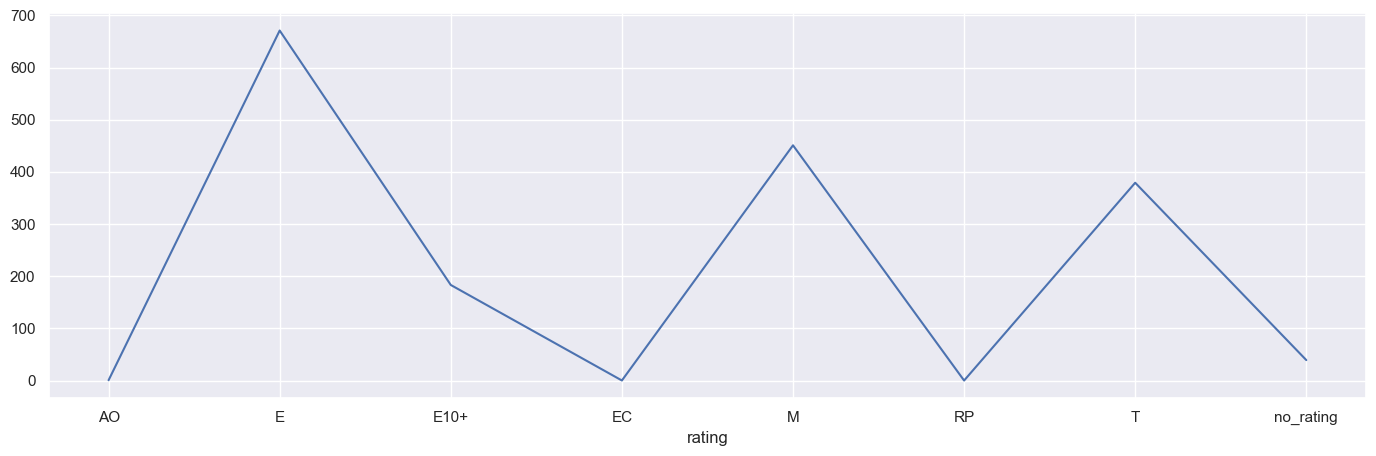

In [88]:
# Выведем график зависимости продаж от рейтинга в Европе после 2003 г.
df.query('year_of_release > 2003')[['eu_sales', 'rating']].groupby('rating')['eu_sales'].sum().plot(grid=True)

<AxesSubplot:xlabel='rating'>

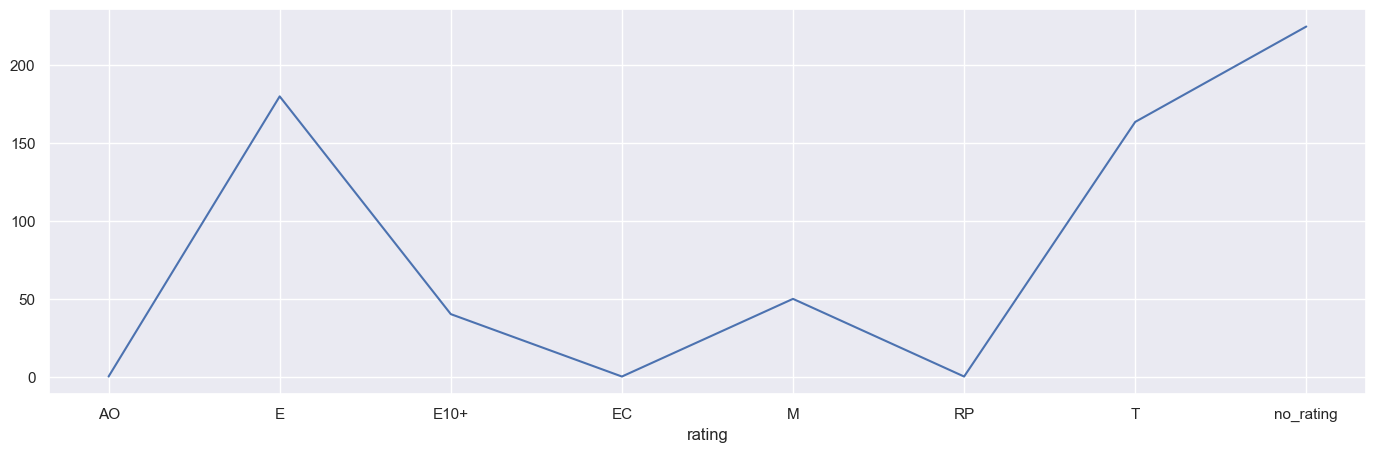

In [89]:
# Выведем график зависимости продаж от рейтинга в Японии после 2003 г.
df.query('year_of_release > 2003')[['jp_sales', 'rating']].groupby('rating')['jp_sales'].sum().plot(grid=True)

**Вывод:**  
*Связь между продажами и рейтингом явно есть. Вряд ли потребители Европы смотрят на рейтинг американсого агенства, однако в этих странах есть аналогичные организации, чьи критерии отнесения игр к категориям вряд ли сильно отличаются от ESRB. В США и Европе графики эдентичны. Категории AO и M мало чем отличаются (18 и 17 лет, и все различие в том, являются ли сексуальные сцены очень откровенными или нет, и длительны ли сцены насилия), так что почти все подходящие игры относят к M, чтобы не отпугнуть продавцов слишком уж жестким контентом. Объем (в денежном выражении) проданных игр для взрослых примерно равен объему игр для подростков. Вообще соотношение игр по рейтингам соответствует распределению по жанрам. Спортивные игры и игры action, судя по всему, вместе в сумме дают максимальную долю игры для всех возрастов.   
В Японии больше всего продавалось игр без рейтинга, скорее всего это локальные японские ролевые игры. Распределение же оставшихся игр между играми с рейтингами E и M аналогично Европе и США.*

## Проверка гипотез.

 ### Гипотеза № 1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [92]:
# Выгрузим интересующие нас совокупности в отдельные переменные, посчитаем их средние
df_XOne = df[(df['platform'] == 'XOne') & (df['user_score'] != -1)]['user_score']
df_PC = df[(df['platform'] == 'PC') & (df['user_score'] != -1)]['user_score']
print('Средний пользовательский рейтинг XOne:', round(df_XOne.mean(), 2))
print('Средний пользовательский рейтинг PC:', round(df_PC.mean(), 2))

Средний пользовательский рейтинг XOne: 6.52
Средний пользовательский рейтинг PC: 7.07


**Нулевая гипотеза Н0:** средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
**Альтернативная гипотеза Н1:** средние пользовательские рейтинги платформ Xbox One и PC разные.

In [93]:
# Проверка гипотезы

#Зададим уровень значимости
alpha = .05

results = st.ttest_ind(df_XOne, df_PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.538577771946039e-06
Отвергаем нулевую гипотезу


**Вывод:**  
*Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые - гипотеза не подтвердилась, средние пользовательские рейтинги платформ Xbox One и PC разные.*



### Гипотеза № 2: Средние пользовательские рейтинги жанров Action и Sports разные.

In [95]:
df_Action = df[(df['genre'] == 'Action') & (df['user_score'] != -1)]['user_score']
df_Sports = df[(df['genre'] == 'Sports') & (df['user_score'] != -1)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', round(df_Action.mean(), 2))
print('Средний пользовательский рейтинг жанра Sports:', round(df_Sports.mean(), 2))

Средний пользовательский рейтинг жанра Action: 7.06
Средний пользовательский рейтинг жанра Sports: 6.95


**Нулевая гипотеза Н0:** средние пользовательские рейтинги жанров Action и Sports одинаковые;  
**Альтернативная гипотеза Н1:** средние пользовательские рейтинги жанров Action и Sports разные.

In [96]:
# Проверка гипотезы

#Зададим уровень значимости 0,05
alpha = .05

results = st.ttest_ind(df_Action,df_Sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.07370214974008267
Не получилось отвергнуть нулевую гипотезу


**Вывод:**  
* Мы отвергаем гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые и признаем их разными.*

## **Итоговый вывод:**  

1 **Открытие файл с данными и изучение общей информации.**  
Данные представляют из себя таблицу: 11 столбцов на 16715 строк, размер 1.4 Mb.  

2	**Подготовка данных.**  
- 2.1 Измененеие названий столбцов.  
    Названия столбцов приведены к нижнему регистру.
- 2.2 Изменение типов данных.  
    Типы данных  следующих столбцах целесообразно заменить:
    - **year_of_release** : целесообразно заменить на int16 (год целое значение не более 2016), замена возможна после обработки пропусков;
    - **_sales** : все столбцы с данными по продажам заменить на тип float32 для экономии памяти;
    - **critic_score** : целесообразно заменить на int16 (рейтинги целые числа до 100), замена возможна после обработки пропусков;
    - **user_score** : целесообразно заменить на float32 (этот рейтинг дробное число до 10), замена возможна после обработки пропусков и нечисловых значений.
- 2.3 Обработка пропусков.  
    Были обнаружены пропуски в следующих столбцах:  
    - **name** и **genre** : две строки с пропущенными значениями в эти двух столбцах, для нас будут бесполезны, были удалены;
    - **year_of_release**  : точная дата, возможна была неизвестна. Некоторые производители выпускают игры сразу для нескольких платформ. Для таких игр можно использовать медианную дату их аналогов для других платформ, оставшиеся назаполненными удалим, так как их количество мало и не повлияет на дальнейший анализ;
    - **critic_score**     : оценки для игр стали вестись не так давно, поэтому игры более ранних периодов таких рейтингов не имеют. Заполним пропущенные значения медианным рейтингом для аналогичного названия как в случае с годом выпуска, остальные заменим нехарактерным значением;  
    - **user_score**       : оценки для игр стали вестись не так давно, поэтому игры более ранних периодов таких рейтингов не имеют. В столбце есть значения 'tbd' (to be determined), то есть оценка еще не определена, возможна игра не вышла официально итд. Считаю, что для нас это аналогично отсутствию оценки, заменим их на nan. Потом заполним пропущенные значения медианным рейтингом для аналогичного названия как в случае с годом выпуска, остальные заменим нехарактерным значением;
    - **rating**           : тот рейтинг от организации ESRB был впервые введен в 1994 г., однако его присвоение стало фактически обязательным для продаж в США намного позже. Заменим пропущенные значения только для игр, вышедших после 2003 г. и продававшихся США, на наиболее часто встречавшееся значение для игр данного жанра. Остальные заменим на 'no_rating'. Также заменим рейтинг 'K+A'(он больше не применяется) на 'E', это его аналог сейчас.     
    После замены пропущенных значений типы данных были преобразованы в те, на которые планировалось.
    
3 **Исследовательский анализ данных.**  
- 3.1 Посмотрим, сколько игр выпускалось в разные годы.  
    С 1980 г. продажи игр неуклонно росли почти 30 лет подряд, вплоть до 2008 г., теперь же они неуклонно снижаются 8-ой год.
- 3.2 Лидеры по продажам среди платформ.  
    Рейтинг лидеров выглядит следующим образом:

       PS2  
       X360
       PS3
       Wii
       DS
       PS
       GBA
       PS4
       PSP
       PC     
   
    В топ-10 вся линейка Sony, X360 от Microsoft, естественно Nintendo и настольные компьютеры. Но это за весь период наблюдений, а нас же интересуют последние тенденции.
    Жизненный цикл консолей лидеров (и соотвественно выпуска игр для них) порядка 10 лет, примерно каждые 5 лет производители запускают следующую платформу в линейке. Судя по графикам после 2008 г. каждая последующая в линейке платформа менее успешна прдыдущей (если судить по продажам игр для них.) и ее жизненный цикл, возможно, будет короче почти вдвое.
    Отдельно следует отметить персональные компьютеры, так как игры для них продаются уже 30 лет, продажи уменьшаются в соответсвии с общей тенденцией, но замыкают десятку лидеров.
- 3.3 Какие платформы лидируют по продажам, растут или падают.
    Только две платформы показывали рост в последние годы: PS4 и XOne, WiiU имеет практически нейтральную тенденцию. Все остальные платформы снижаются.
- 3.4 График «ящик с усами» по глобальным продажам игр в разбивке по платформам.  
    Следует отметить большое кол-во сильных выбросов у всех платформ. Это может говорить о том, что есть отдельные игры (и таких игр не так уж и мало) объем продаж которых существенно превосходит объемы продаж по остальным играм для платформы. Медианы у всех лидеров последних годов примерно одинаковые.
- 3.5 Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.  
    Отзывы критиков слабо влияют на продажи игр, а пользователей вообще не влияют.
- 3.6 Общее распределение игр по жанрам.  
   Если брать суммарный объем продаж за последние пять лет, на первом месте жанр Action, его практически догнал жанр Shooter, третье/четвертое место делят между собой ролевые и спортивные игры. Спортивные игры явно уступили свои позиции, как и жанр Platform, хотя ранее были очень популярны и, если брать весь период наблюдений, то они займут 2-ое и 5-ое места соответственно. Головоломки и стратегия традиционно на последних местах - выпускают мало игр этих жанрво и мало продают, так как люди предпочитают отдыхать, а не думать головой во время игры.  
    Однако самым продаваемы стал жанр Shooter, в 2015 г. выручка на одну игру этого жанра почти в 4 раза превышала игры из любых других жанров. Рост наблюдается с 2013 года.  

4 **Составление портрета пользователя каждого региона.**  
На первом месте по продажам США, далее Европа, доля Японии примерно равна продажам всего остального мира. Графики повторяют друг друга, отличается только масштаб.  
- 4.1 Самые популярные платформы (топ-5) по регионам.  
    Топ-5 платформ по странам:

       США     Европа   Япония
       X360     PS2      DS
       PS2      PS3      PS
       Wii      X360     PS2
       PS3      Wii      SNES
       DS       PS       3DS
    
   Продажи по платформам различаются в зависимости от региона. В Японии в лидерах компания Nintendo, в том числе в лидерах 2 консольные платформы. Ее платформа Wii среди лидеров в Европе и США, а вот на своей родине она не стала столь популярной. В США на первом месте естественно Microsoft с X360. Платформы Sony представлены среди лидеров всех регионом, но в Европе они занимают 3 из  5-ти лидерских позиций.    
   
- 4.2 Самые популярные жанры (топ-5) по регионам.
    Топ-5 жанров по странам:

        США     Европа   Япония
        Action   Action  Role-Playing
        Sports   Sports  Action
        Shooter  Shooter Sports
        Platform Racing  Platform
        Misk     Misk    Misk
        
    Различия ясно видны даже на круговых диаграммах. Жанровые предпочтения европейцев и жителей США практически аналогичны, только в Европе любят больше гонки, чем Platform. А вот японцы явно не любят стрелялки, почти всю их долю забрали себе ролевые игры (они занимают более четверти всех проданных игр), также японцы чуть больше любят стретегии и приключения, и меньше гонки, распределение остальных жанров у них схоже.   
    
- 4.3 Влияние рейтинг ESRB на продажи в отдельном регионе.  
    Связь между продажами и рейтингом явно есть. Вряд ли потребители Европы смотрят на рейтинг американсого агенства, однако в этих странах есть аналогичные организации, чьи критерии отнесения игр к категориям вряд ли сильно отличаются от ESRB. В США и Европе графики эдентичны. Категории AO и M мало чем отличаются (18 и 17 лет, и все различие в том, являются ли сексуальные сцены очень откровенными или нет, и длительны ли сцены насилия), так что почти все подходящие игры относят к M, чтобы не отпугнуть продавцов слишком уж жестким контентом. Объем (в денежном выражении) проданных игр для взрослых примерно равен объему игр для подростков. Вообще соотношение игр по рейтингам соответствует распределению по жанрам. Спортивные игры и игры action, судя по всему, вместе в сумме дают максимальную долю игры для всех возрастов.     
    В Японии больше всего продавалось игр без рейтинга, скорее всего это локальные японские ролевые игры. Распределение же оставшихся игр между играми с рейтингами E и M аналогично Европе и США.

5 **Проверка гипотез.**
 - 5.1 Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые - гипотеза не подтвердилась, средние пользовательские рейтинги платформ Xbox One и PC разные.
 - 5.2 Cредние пользовательские рейтинги жанров Action и Sports разные - мы отвергаем гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые и признаем гипотезу, что они разные.